# Adding small communities to de Boer (2000)

Having recreated and validated found results of de Boer (2000) together with a less ad hoc variant of the Bark Operator we shift our focus on extending de Boer (2000).
As we discuss in the report, this extension is in changing the interaction network of the agents.
Instead of randomly picking a speaker and and imitator, we use a selection strategy based on a small community.
We have different roles in this small community, which each have their own characteristic properties.


**References**

de Boer, B. (2000). Self-organization in vowel systems. *In Journal of Phonetics (Vol. 28, Issue 4, pp. 441–465)*. Elsevier BV. https://doi.org/10.1006/jpho.2000.0125


<hr>
<hr>

## Table of contents

- Student information
- Required imports
- Adding an extra CommunityRole enum and CommunityBehaviour class
- Extending the agent class
- Creating custom game state
- Creating custom game engine
- Playing sample games

<hr>
<hr>

## Student information

- **Name**: Bontinck Lennert
- **Student ID**: 568702
- **Affiliation**: VUB - Master Computer Science: AI

<hr>
<hr>

## Required imports

Below we import the required things for this notebook.

In [49]:
# Import imitation game classes made in the previous notebook
from imitationGameClasses import Agent, Synthesizer, BarkOperator, Sound, Utterance;

# Used for saving and loading variables
import pickle;

# Used for easier numerical operations
import random as rnd;

# Enum for role
from enum import Enum;

# Deep copy lists
import copy;

# Used for plotting
import matplotlib.pyplot as plt;

<hr>
<hr>

## Adding an extra CommunityRole enum and CommunityBehaviour class

In order to represent the role of the community member (agent), we make a simple enum type.
The idea is as follows, imagine that the `category_age_width` is 20

- There are 7 babies, each of these have 1 parent and 1 grandparent. 
   - This parent is either a regular parent or a docterate, respectively this grandparent is either a professor or a grandparent
   - after 10 years (`category_age_width` / 2) the babies become students
   - after 10 more years (20 since baby), the students become parents or docterates, depending on their own parent
- There are 5 parents who lost their grandparent but still have a parent
- There are 5 grandparents
- There are 2 docterates who lost their grandparent but still have a parent (a professor)
- There are 2 professors
- In total we have in total: 7 + 5 + 2 + 5 + 2 = 7 * 3 = 21 agents in this configuration



In [50]:
class CommunityRole(Enum):
    """This is an enum used to represent the agent's community role."""
    PROFESSOR = 1;
    DOCTERATE = 2;
    STUDENT = 3;
    BABY = 4;
    PARENT = 5;
    GRANDPARENT = 6;
    MYPARENT = 7;
    MYGRANDPARENT = 8;

To represent the influence and other community based parameters for an agent we add a CommunityBehaviour class.

In [51]:
class CommunityBehaviour():
    """This is a class used to represent the innfluence and other community based parameters for an agent."""
    def __init__(self, new_sound_prob: float, phoneme_step_size: float, influence_dictionary: float,
                 synthesizer: Synthesizer, influential_agent_types: list):
        """Creates a CommunityBehaviour instance."""
        # Chance of adding new random vowel
        self.new_sound_prob = new_sound_prob;
        
        # Step size control
        self.phoneme_step_size = phoneme_step_size;

        # Influence of specific roles
        self.influence_dictionary = influence_dictionary
        
        # Noise control
        self.synthesizer = synthesizer;
        
        # Types of agents that can influence immitator to create new vowel
        self.influential_agent_types = influential_agent_types;

<hr>
<hr>

## Extending the agent class



In [52]:
# Defining child class so that Agent methods are copied
class CommunityAgent(Agent):
      
    # Constructor
    def __init__(self, synthesizer: Synthesizer, bark_operator: BarkOperator,
                    community_role : CommunityRole, community_behaviour: CommunityBehaviour,
                    logger: bool = False,
                    phoneme_step_size: float = 0.1, max_similar_sound_loops: int = 20, max_semi_random_loop: int = 5,
                    sound_threshold_game: float = 0.5, sound_threshold_agent:float = 0.7, sound_minimum_tries: int = 5,
                    cleanup_prob = 0.1, new_sound_prob = 0.01, merge_prob = 1      
                ):
        
        # Use init of Agent
        Agent.__init__(self, synthesizer = synthesizer, bark_operator = bark_operator,
                       logger = logger, phoneme_step_size = phoneme_step_size,
                       max_similar_sound_loops = max_similar_sound_loops,
                       max_semi_random_loop = max_semi_random_loop, sound_threshold_game = sound_threshold_game,
                       sound_threshold_agent = sound_threshold_agent, sound_minimum_tries = sound_minimum_tries,
                       cleanup_prob = cleanup_prob, new_sound_prob = new_sound_prob,
                       merge_prob = merge_prob);
        
        # Store community role
        self.community_role = community_role;
        
        # Store community behaviour
        self.community_behaviour = community_behaviour;
        
    # Prepare for the current game
    def prepare_current_game(self, oponent_role: CommunityRole):
        """Prepare parameters to reflect oponent of current game."""
        # Save role of oponent for game
        self.oponent_role = oponent_role;
        
    # Prepare for the current game
    def change_agent_role_and_behaviour(self, new_role: CommunityRole, new_behaviour: CommunityBehaviour):
        """Prepare parameters to reflect oponent of current game."""
        # Store community role
        self.community_role = new_role;
        
        # Store community behaviour
        self.community_behaviour = new_behaviour;
        
        if self.logger:
            print(f"{self.name}: update my role and behaviour to reflect {new_role.name}.");

        
    # Edit so that we perform multiple loops based on influence
    def improve_sound(self, original_sound: Sound, goal_utterance: Utterance):
        """Returns improved original sound which is more like the goal sound.
        Considers all permutations of phoneme using phoneme_step_size and loops corresponding to oponent influence"""
        for _ in range(self.community_behaviour.influence_dictionary[self.oponent_role]):
            result = super().improve_sound(original_sound, goal_utterance);

        return result;

    # Edit so that we only change our vowel repetoire if we "care about" the oponent
    def process_non_verbal_imitation_confirmation(self, was_success):
        """Processes the non verbal confirmation if an imitation was correct, ending the game cycle."""
        if was_success:
            # Save success
            self.known_sounds[self.last_spoken_sound].was_success();
            # "Shift closer" if we care about oponent agent
            if self.oponent_role in self.community_behaviour.influential_agent_types:
                improved_sound = self.improve_sound(self.known_sounds[self.last_spoken_sound], self.last_heard_utterance);
                self.known_sounds[self.last_spoken_sound].improve(improved_sound);
        else:
            if self.known_sounds[self.last_spoken_sound].success_ratio() < self.sound_threshold_game:
                # Probably bad sound - "Shift closer" and we care about oponent
                if self.oponent_role in self.community_behaviour.influential_agent_types:
                    improved_sound = self.improve_sound(self.known_sounds[self.last_spoken_sound], self.last_heard_utterance);
                    self.known_sounds[self.last_spoken_sound].improve(improved_sound);
            else:
                # Probably good sound - add new sound to repetoire if we care about oponent
                if self.oponent_role in self.community_behaviour.influential_agent_types:
                    self.add_similar_sound(self.last_heard_utterance);


        if self.logger:
            if was_success:
                print(self.name + ": had a confirmed match, changed my sound to match closer.");

        # End of current game
        self.prepare_for_new_game(was_imitator=True, was_succes= was_success);


<hr>
<hr>

## Creating custom game state

We now create a custom game state to have more representative plots.

In [53]:
class CommunityGameState:
    """This is a class used to represent the state of a game."""
    def __init__(self, agents: list, iteration: int):
        """Creates a Game Engine instance.
        - agents: list of agent objects to be stored
        - iteration: iteration count at which this game state was captured"""
        self.agents = copy.deepcopy(agents);
        self.iteration = iteration;

    def plot(self, title: str = None, show_legend: bool = True):
        # Change plot size and color, then start new plot 
        plt.rcParams["figure.figsize"] = (10,10);
        plt.rcParams['figure.facecolor'] = 'white';
        plt.figure();

        # Plot babies
        babies = [a for a in self.agents if a.community_role in [CommunityRole.BABY]]
        f1 = [];
        f2 = [];
        for baby in babies:
            f1 += [baby.bark_operator.bark_f1(sound.utterance) for sound in baby.known_sounds];
            f2 += [baby.bark_operator.bark_f2(sound.utterance) for sound in baby.known_sounds];
        
        plt.plot(f2, f1, 'o', label="Babies");

        # Plot students
        students = [a for a in self.agents if a.community_role in [CommunityRole.STUDENT]]
        f1 = [];
        f2 = [];
        for student in students:
            f1 += [student.bark_operator.bark_f1(sound.utterance) for sound in student.known_sounds];
            f2 += [student.bark_operator.bark_f2(sound.utterance) for sound in student.known_sounds];
        
        plt.plot(f2, f1, 'o', label="Students");

        # Plot parents
        parents = [a for a in self.agents if a.community_role in [CommunityRole.PARENT]]
        f1 = [];
        f2 = [];
        for parent in parents:
            f1 += [parent.bark_operator.bark_f1(sound.utterance) for sound in parent.known_sounds];
            f2 += [parent.bark_operator.bark_f2(sound.utterance) for sound in parent.known_sounds];
        
        plt.plot(f2, f1, 'x', label="Parents");

        # Plot grandparents
        grandparents = [a for a in self.agents if a.community_role in [CommunityRole.GRANDPARENT]]
        f1 = [];
        f2 = [];
        for grandparent in grandparents:
            f1 += [grandparent.bark_operator.bark_f1(sound.utterance) for sound in grandparent.known_sounds];
            f2 += [grandparent.bark_operator.bark_f2(sound.utterance) for sound in grandparent.known_sounds];
        
        plt.plot(f2, f1, 'x', label="Grandparents");

        # Plot docterates
        docterates = [a for a in self.agents if a.community_role in [CommunityRole.DOCTERATE]]
        f1 = [];
        f2 = [];
        for docterate in docterates:
            f1 += [docterate.bark_operator.bark_f1(sound.utterance) for sound in docterate.known_sounds];
            f2 += [docterate.bark_operator.bark_f2(sound.utterance) for sound in docterate.known_sounds];
        
        plt.plot(f2, f1, 's', label="Docterates");

        # Plot professors
        professors = [a for a in self.agents if a.community_role in [CommunityRole.PROFESSOR]]
        f1 = [];
        f2 = [];
        for professor in professors:
            f1 += [professor.bark_operator.bark_f1(sound.utterance) for sound in professor.known_sounds];
            f2 += [professor.bark_operator.bark_f2(sound.utterance) for sound in professor.known_sounds];
        
        plt.plot(f2, f1, 's', label="Professor");

        # Set titles
        if title == None:
            plt.title(str(self.iteration) + " games");
        else:
            plt.title(title);
        plt.xlabel("F'2 in bark");
        plt.ylabel("F1 in bark");
        
        # Change pot parameters
        plt.ylim(1, 8);
        plt.xlim(7, 16);
        plt.gca().invert_xaxis();
        plt.gca().invert_yaxis();
        plt.grid();

        # Show legend
        if show_legend:
            plt.legend(title="Agents community role", loc="lower left");

        # Reset figure size for next figures
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
        plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

    def plot_highly_schooled(self, title: str = None, show_legend: bool = True):
        # Change plot size and color, then start new plot 
        plt.rcParams["figure.figsize"] = (10,10);
        plt.rcParams['figure.facecolor'] = 'white';
        plt.figure();

        # Plot docterates
        docterates = [a for a in self.agents if a.community_role in [CommunityRole.DOCTERATE]]
        f1 = [];
        f2 = [];
        for docterate in docterates:
            f1 += [docterate.bark_operator.bark_f1(sound.utterance) for sound in docterate.known_sounds];
            f2 += [docterate.bark_operator.bark_f2(sound.utterance) for sound in docterate.known_sounds];
        
        plt.plot(f2, f1, 's', label="Docterates");

        # Plot professors
        professors = [a for a in self.agents if a.community_role in [CommunityRole.PROFESSOR]]
        f1 = [];
        f2 = [];
        for professor in professors:
            f1 += [professor.bark_operator.bark_f1(sound.utterance) for sound in professor.known_sounds];
            f2 += [professor.bark_operator.bark_f2(sound.utterance) for sound in professor.known_sounds];
        
        plt.plot(f2, f1, 's', label="Professor");

        # Set titles
        if title == None:
            plt.title(str(self.iteration) + " games");
        else:
            plt.title(title);
        plt.xlabel("F'2 in bark");
        plt.ylabel("F1 in bark");
        
        # Change pot parameters
        plt.ylim(1, 8);
        plt.xlim(7, 16);
        plt.gca().invert_xaxis();
        plt.gca().invert_yaxis();
        plt.grid();

        # Show legend
        if show_legend:
            plt.legend(title="Agents community role", loc="lower left");

        # Reset figure size for next figures
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
        plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

    def plot_regular_schooled(self, title: str = None, show_legend: bool = True):
        # Change plot size and color, then start new plot 
        plt.rcParams["figure.figsize"] = (10,10);
        plt.rcParams['figure.facecolor'] = 'white';
        plt.figure();

        # Plot parents
        parents = [a for a in self.agents if a.community_role in [CommunityRole.PARENT]]
        f1 = [];
        f2 = [];
        for parent in parents:
            f1 += [parent.bark_operator.bark_f1(sound.utterance) for sound in parent.known_sounds];
            f2 += [parent.bark_operator.bark_f2(sound.utterance) for sound in parent.known_sounds];
        
        plt.plot(f2, f1, 'x', label="Parents");

        # Plot grandparents
        grandparents = [a for a in self.agents if a.community_role in [CommunityRole.GRANDPARENT]]
        f1 = [];
        f2 = [];
        for grandparent in grandparents:
            f1 += [grandparent.bark_operator.bark_f1(sound.utterance) for sound in grandparent.known_sounds];
            f2 += [grandparent.bark_operator.bark_f2(sound.utterance) for sound in grandparent.known_sounds];
        
        plt.plot(f2, f1, 'x', label="Grandparents");

        # Set titles
        if title == None:
            plt.title(str(self.iteration) + " games");
        else:
            plt.title(title);
        plt.xlabel("F'2 in bark");
        plt.ylabel("F1 in bark");
        
        # Change pot parameters
        plt.ylim(1, 8);
        plt.xlim(7, 16);
        plt.gca().invert_xaxis();
        plt.gca().invert_yaxis();
        plt.grid();

        # Show legend
        if show_legend:
            plt.legend(title="Agents community role", loc="lower left");

        # Reset figure size for next figures
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"];
        plt.rcParams["figure.facecolor"] = plt.rcParamsDefault["figure.facecolor"];

<hr>
<hr>

## Creating custom game engine

We now create a custom game engine to play the more complex game.
For this we need instances of the previously added CommunityBehaviour class for each type of agent.

In [54]:
class CommunityGameEngine:
    """This is a class used to represent an imitation game egine."""
    def __init__(self,
                 community_member_amounts: dict,
                 community_behaviours: dict,
                 category_age_width: int,
                 
                 iterations: int, bark_operator: BarkOperator, 
                 agent_sound_threshold_game: float = 0.5, agent_sound_threshold_self:float = 0.7,
                 agent_sound_minimum_tries: int = 5):
        """Creates a Community Game Engine instance for the provided community settings."""
        
        # Keep track of number of agents
        self.community_member_amounts = community_member_amounts;
        
        total_amount_of_agents = 0;
        for community_role in community_member_amounts:
            total_amount_of_agents += community_member_amounts[community_role];
        
        # Keep track of community behaviours
        self.community_behaviours = community_behaviours;
        
        # Keep track of number of iterations
        self.iterations = iterations;
        
        # Keep track of age group width
        self.category_age_width = category_age_width;
        
        # Keep track of bark operator etc
        self.bark_operator = bark_operator;
        self.agent_sound_threshold_game = agent_sound_threshold_game;
        self.agent_sound_threshold_self = agent_sound_threshold_self;
        self.agent_sound_minimum_tries = agent_sound_minimum_tries;

        # Create the agents
        self.agents = [];
                
        for community_role in community_member_amounts:
            self.agents += [CommunityAgent(synthesizer= community_behaviours[community_role].synthesizer,
                                           bark_operator= bark_operator, 
                                           community_role = community_role,
                                           logger = False,
                                           phoneme_step_size = community_behaviours[community_role].phoneme_step_size,
                                           community_behaviour = community_behaviours[community_role],
                                           sound_threshold_game= agent_sound_threshold_game,
                                           sound_threshold_agent= agent_sound_threshold_self,
                                           sound_minimum_tries= agent_sound_minimum_tries,
                                           new_sound_prob = community_behaviours[community_role].new_sound_prob)
                            for n in range(community_member_amounts[community_role])];
            
        # Keep track of parents of agents
        # Initially we only have babies, no students, and those babies have parents and grandparents
        #   The docterates and parents still have a parent
        self.parent_tree = {};

        babies = [a for a in self.agents if a.community_role == CommunityRole.BABY];
        docterates = [a for a in self.agents if a.community_role == CommunityRole.DOCTERATE];
        parents = [a for a in self.agents if a.community_role == CommunityRole.PARENT];
        grandparents = [a for a in self.agents if a.community_role == CommunityRole.GRANDPARENT];
        professors = [a for a in self.agents if a.community_role == CommunityRole.PROFESSOR];

        i = 0;
        for baby in babies:
            self.parent_tree[baby] = (parents + docterates)[i]

        i = 0;
        for parent in parents:
            self.parent_tree[parent] = grandparents[i]

        i = 0;
        for docterate in docterates:
            self.parent_tree[docterate] = professors[i]

            
    def __play_one_agent_pair(self, speaker: CommunityAgent, imitator: CommunityAgent):
        # prepare agents
        speaker.prepare_current_game(imitator.community_role);
        imitator.prepare_current_game(speaker.community_role);
        
        # play game
        start_utterance = speaker.say_something();
        imitated_utterance = imitator.imitate_sound(start_utterance);
        validation = speaker.validate_imitation(imitated_utterance);
        imitator.process_non_verbal_imitation_confirmation(validation);
        

    def __play_full_agent_aging_round(self):
        """Plays an imitation game round where all agents play so that age evolves constant across agents. """
        # Chose pairs such that each agent is a listener at least once
        for community_role in self.community_member_amounts:
            # Determine all agents of that type
            agents_of_type = [a for a in self.agents if a.community_role == community_role];
            
            # Determine to whom the agents of that type may listen
            possible_speakers = [a for a in self.agents if a.community_role in self.community_behaviours[community_role].influential_agent_types]
                
            # Find all agents of that role and play game as imitator
            for imitator in agents_of_type:
                # Add parents to possible speakers if wanted
                if (CommunityRole.MYPARENT in imitator.community_behaviour.influential_agent_types):
                    possible_speakers += [self.parent_tree[imitator]];

                # Add grandparents to possible speakers if wanted
                if (CommunityRole.MYGRANDPARENT in imitator.community_behaviour.influential_agent_types):
                    possible_speakers += [self.parent_tree[self.parent_tree[imitator]]];
                
                # Find a speaker from the preffered speakers but ensure it is not agent himself
                while True:
                    speaker = rnd.choice(possible_speakers);
                    if imitator != speaker:
                        break;
                
                    
                # Play game
                self.__play_one_agent_pair(speaker, imitator);
        
    def play_imitation_game(self, checkpoints: list):
        """Plays an imitation game and returns a vector of CommunityGameState objects.
        - checkpoints: list of iteration numbers at which the state of the game should be saved (after playing that iteration)."""
        
        game_states = [None] * len(checkpoints);

        for i in range(self.iterations):
            # Play one iteration of the game
            self.__play_full_agent_aging_round();

            # After playing the games, check if checkpoint reached for storing
            if i + 1 in checkpoints:
                # Force merge of agent for Energy measure
                for agent in self.agents:
                    agent.merge_similar_sound();
                    
                # Store imitation game state
                game_states[checkpoints.index(i + 1)] = CommunityGameState(self.agents, i + 1);
            
            
            # Check if half aging round (babies become student)
            if i % (self.category_age_width/2) == 0 and i != 0 and i % self.category_age_width != 0:
                # TODO: remove
                print(f"Round {i}: babies become students");

                # make babies students
                babies = [a for a in self.agents if a.community_role == CommunityRole.BABY];
                for baby in babies:
                    baby.change_agent_role_and_behaviour(new_role = CommunityRole.STUDENT,
                                                         new_behaviour = self.community_behaviours[CommunityRole.STUDENT]);
            
            # Check if full aging round (every category shifts one ladder up)
            if i % self.category_age_width == 0 and i != 0:
                # TODO: remove
                print(f"Round {i}: shift everyone up");

                # Kill professors and grandparents
                dead_agents = [a for a in self.agents if a.community_role in [CommunityRole.GRANDPARENT, CommunityRole.PROFESSOR]];
                for dead_agent in dead_agents:
                    if dead_agent in self.parent_tree: 
                        del self.parent_tree[dead_agent];
                    self.agents.remove(dead_agent);
                    
                # make docterates professors
                docterates = [a for a in self.agents if a.community_role == CommunityRole.DOCTERATE];
                for docterate in docterates:
                    docterate.change_agent_role_and_behaviour(new_role = CommunityRole.PROFESSOR, 
                                                              new_behaviour = self.community_behaviours[CommunityRole.PROFESSOR]);
                    
                
                # make parents grandparents
                parents = [a for a in self.agents if a.community_role == CommunityRole.PARENT];
                for parent in parents:
                    parent.change_agent_role_and_behaviour(new_role = CommunityRole.GRANDPARENT, 
                                                           new_behaviour = self.community_behaviours[CommunityRole.GRANDPARENT]);
                    
                # make students either docterate or parent depending on parent
                students = [a for a in self.agents if a.community_role == CommunityRole.STUDENT];
                for student in students:
                    if self.parent_tree[student].community_role in [CommunityRole.DOCTERATE, CommunityRole.PROFESSOR]:
                        student.change_agent_role_and_behaviour(new_role = CommunityRole.DOCTERATE,
                                                                new_behaviour = self.community_behaviours[CommunityRole.DOCTERATE]);
                        
                    if self.parent_tree[student].community_role in [CommunityRole.PARENT, CommunityRole.GRANDPARENT]:
                        student.change_agent_role_and_behaviour(new_role = CommunityRole.PARENT,
                                                                new_behaviour = self.community_behaviours[CommunityRole.PARENT]);
                    
                # create new babies, one for each parent
                new_parents = [a for a in self.agents if a.community_role in [CommunityRole.PARENT, CommunityRole.DOCTERATE]];
                for parent in new_parents:
                    new_baby = [CommunityAgent(synthesizer= self.community_behaviours[CommunityRole.BABY].synthesizer,
                                               bark_operator= self.bark_operator, 
                                               community_role = CommunityRole.BABY,
                                               community_behaviour = self.community_behaviours[CommunityRole.BABY],
                                               sound_threshold_game= self.agent_sound_threshold_game,
                                               sound_threshold_agent= self.agent_sound_threshold_self,
                                               sound_minimum_tries= self.agent_sound_minimum_tries,
                                               new_sound_prob = self.community_behaviours[CommunityRole.BABY].new_sound_prob)];
                                        
                    # Store new baby and its parent
                    self.agents += new_baby;
                    self.parent_tree[new_baby[0]] = parent;

        # Return the game states
        return game_states;

<hr>
<hr>

## Playing sample game

We now play a sample game to validate our created code

In [55]:
bark_operator = BarkOperator(critical_distance = 3.5, second_formant_weight = 0.3);
community_member_amounts = {
    CommunityRole.BABY: 7,
    CommunityRole.DOCTERATE: 2,
    CommunityRole.PROFESSOR: 2,
    CommunityRole.PARENT: 5,
    CommunityRole.GRANDPARENT: 5,
    }

community_behaviours = {
    CommunityRole.BABY: CommunityBehaviour(
      new_sound_prob = 0.05,
      synthesizer = Synthesizer(max_noise_ambient = 0.1),
      phoneme_step_size = 0.3,
      influential_agent_types = [CommunityRole.MYPARENT, CommunityRole.MYGRANDPARENT],
      influence_dictionary = {
        CommunityRole.BABY: 1,
        CommunityRole.STUDENT: 1,
        CommunityRole.DOCTERATE: 1,
        CommunityRole.PROFESSOR: 1,
        CommunityRole.PARENT: 1,
        CommunityRole.GRANDPARENT: 1,
        }),

    CommunityRole.STUDENT: CommunityBehaviour(
      new_sound_prob = 0.03,
      synthesizer = Synthesizer(max_noise_ambient = 0.1),
      phoneme_step_size = 0.1,
      influential_agent_types = [CommunityRole.MYPARENT, CommunityRole.MYGRANDPARENT, CommunityRole.STUDENT, CommunityRole.PROFESSOR],
      influence_dictionary = {
        CommunityRole.BABY: 0,
        CommunityRole.STUDENT: 2,
        CommunityRole.DOCTERATE: 3,
        CommunityRole.PROFESSOR: 4,
        CommunityRole.PARENT: 1,
        CommunityRole.GRANDPARENT: 1,
        }),

    CommunityRole.DOCTERATE: CommunityBehaviour(
      new_sound_prob = 0.01,
      synthesizer = Synthesizer(max_noise_ambient = 0.1),
      phoneme_step_size = 0.025,
      influential_agent_types = [CommunityRole.MYPARENT, CommunityRole.DOCTERATE, CommunityRole.PROFESSOR],
      influence_dictionary = {
        CommunityRole.BABY: 0,
        CommunityRole.STUDENT: 0,
        CommunityRole.DOCTERATE: 2,
        CommunityRole.PROFESSOR: 3,
        CommunityRole.PARENT: 1,
        CommunityRole.GRANDPARENT: 0,
        }),

    CommunityRole.PROFESSOR: CommunityBehaviour(
      new_sound_prob = 0.005,
      synthesizer = Synthesizer(max_noise_ambient = 0.1),
      phoneme_step_size = 0.01,
      influential_agent_types = [CommunityRole.PROFESSOR],
      influence_dictionary = {
        CommunityRole.BABY: 0,
        CommunityRole.STUDENT: 0,
        CommunityRole.DOCTERATE: 1,
        CommunityRole.PROFESSOR: 2,
        CommunityRole.PARENT: 0,
        CommunityRole.GRANDPARENT: 0,
        }),

    CommunityRole.PARENT: CommunityBehaviour(
      new_sound_prob = 0.01,
      synthesizer = Synthesizer(max_noise_ambient = 0.1),
      phoneme_step_size = 0.05,
      influential_agent_types = [CommunityRole.MYPARENT, CommunityRole.PARENT, CommunityRole.PROFESSOR],
      influence_dictionary = {
        CommunityRole.BABY: 0,
        CommunityRole.STUDENT: 1,
        CommunityRole.DOCTERATE: 2,
        CommunityRole.PROFESSOR: 3,
        CommunityRole.PARENT: 1,
        CommunityRole.GRANDPARENT: 1,
        }),
                                                 
    CommunityRole.GRANDPARENT: CommunityBehaviour(
      new_sound_prob = 0.005,
      synthesizer = Synthesizer(max_noise_ambient = 0.1),
      phoneme_step_size = 0.05,
      influential_agent_types = [CommunityRole.GRANDPARENT, CommunityRole.PROFESSOR],
      influence_dictionary = {
        CommunityRole.BABY: 0,
        CommunityRole.STUDENT: 1,
        CommunityRole.DOCTERATE: 2,
        CommunityRole.PROFESSOR: 3,
        CommunityRole.PARENT: 1,
        CommunityRole.GRANDPARENT: 1,
        }),
    }

community_game_engine = CommunityGameEngine(community_member_amounts = community_member_amounts,
                                            community_behaviours = community_behaviours,
                                            category_age_width = 40000000000000000,
                                            iterations = 2000,
                                            bark_operator = bark_operator);

In [56]:
checkpoints = [200, 400, 800, 1600, 2000];
results = community_game_engine.play_imitation_game(checkpoints);

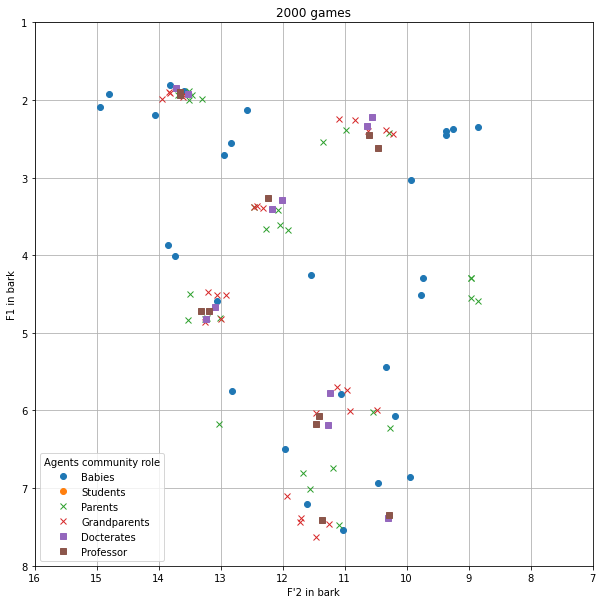

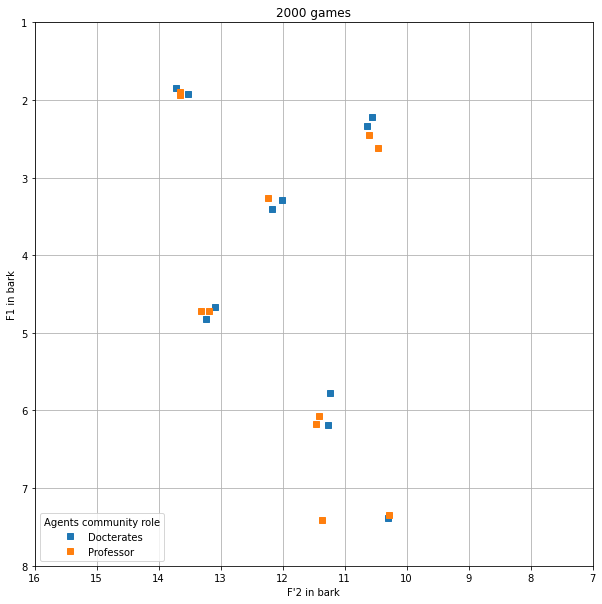

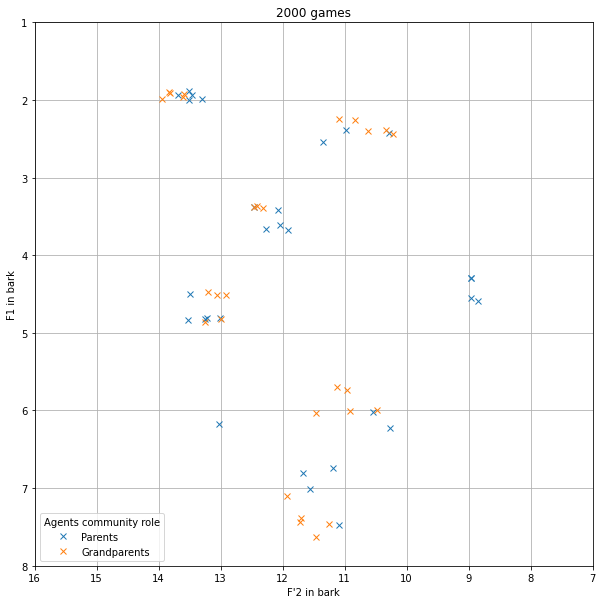

In [57]:
results[-1].plot();
results[-1].plot_highly_schooled();
results[-1].plot_regular_schooled();

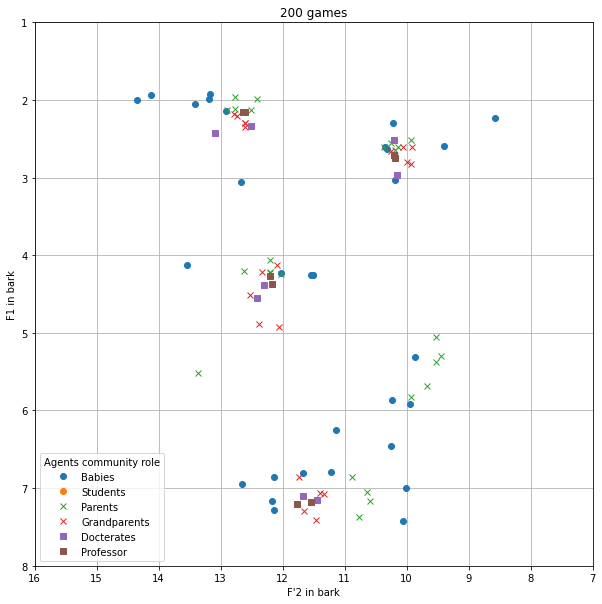

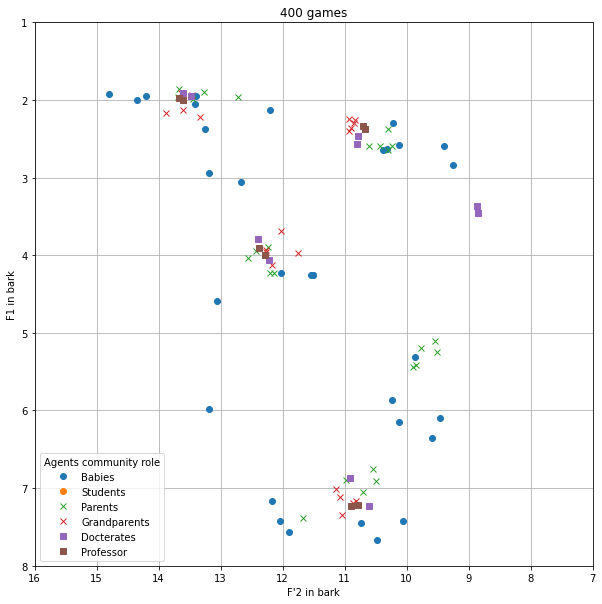

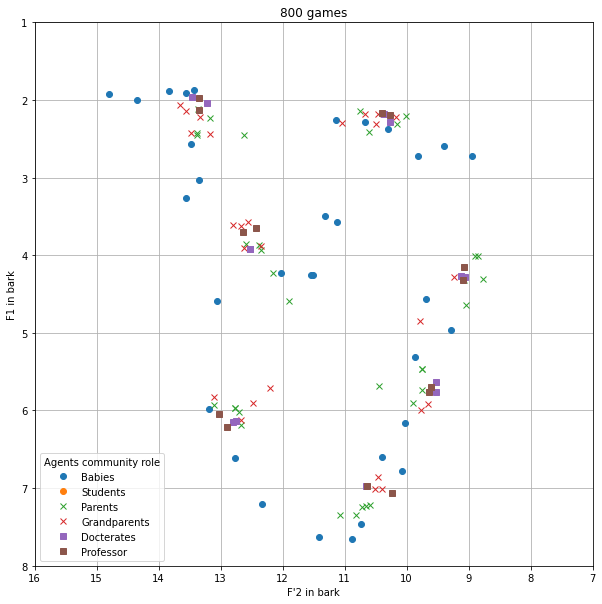

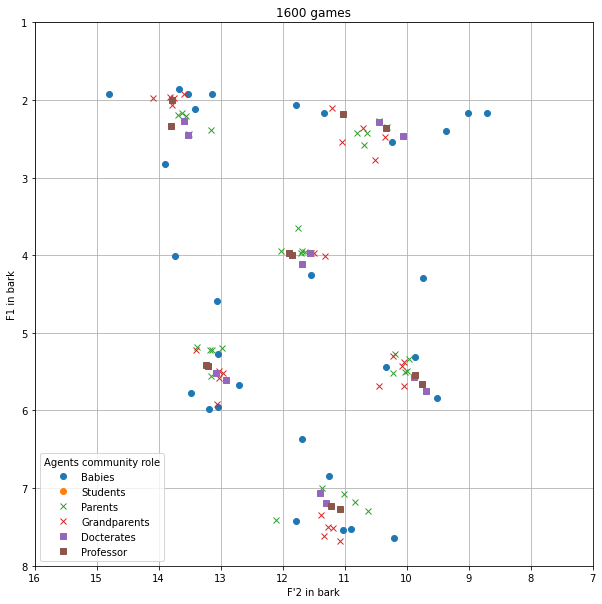

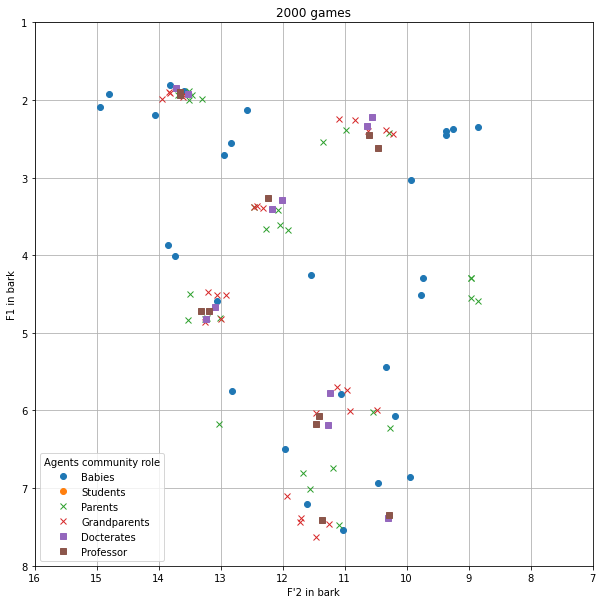

In [58]:
for game_state in results:
    game_state.plot();